<a href="https://colab.research.google.com/github/Terry-50000/Best-AI-Agents/blob/main/S%26P_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pandas_ta
!curl -L http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O && tar xzvf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd - && pip install ta-lib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   2547      0 --:--:-- --:--:-- --:--:--  2550
100   379  100   379    0     0   1260      0 --:--:-- --:--:-- --:--:--  1260
100 1299k  100 1299k    0     0  1927k      0 --:--:-- --:--:-- --:--:-- 1927k
ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/outpu

In [13]:
import numpy as np
import pandas as pd
import keras
from keras import Sequential
from keras.src.layers import Dense, LSTM, CuDNNLSTM, Dropout, BatchNormalization
from keras.src.optimizers import Adam, SGD, RMSprop
from keras.src.callbacks import Callback, EarlyStopping
from keras.src.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.src.losses import mean_squared_error, CosineSimilarity
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sns

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from imblearn.over_sampling import BorderlineSMOTE

import datetime as dt
import yfinance as yf
import pandas_ta as ta
import tensorflow as tf
# import mplfinance as mpf
import talib as tb

In [14]:

forward = 6
stock = ['^GSPC']
drop_na = True
df = pd.DataFrame()

print('Processing symbol ', stock)
df = yf.download(stock, period='60d', interval='5m')
## Adding some columns into the the df

# # Relative Strength Index (RSI)
# df.ta.rsi(length=14, append=True) #How quickly a stock's price is rising or falling. It calculates RSI based on the last 14 days of price data.

# # Simple Moving Average (SMA)
# df.ta.sma(length=50, append=True) # smoothens price data to identify trends over a specified period e.g. 50 days

# # Exponential Moving Average (EMA)
# df.ta.ema(length=20, append=True) #  gives more weight to recent prices, making it responsive to short-term changes. last 20 days

# # Moving Average Convergence Divergence (MACD)
# df.ta.macd(fast=12, slow=26, signal=9, append=True) #  helps identify trends and potential trend reversals. 9-day exponential moving average of the MACD line

# # Average True Range (ATR)
# df.ta.atr(length=14, append=True) # measures market volatility, indicating potential price movement. last 14 days

# # Standard Deviation (STD)
# df.ta.stdev(length=20, append=True) # measures how spread out values are from the average

# # Bollinger Bands
# df.ta.bbands(length=20, append=True) # identify volatility and potential reversal points.

# # Stochastic Oscillator
# df.ta.stoch(fast=14, slow=3, append=True) # identifies overbought or oversold conditions.

o = df['Open'].values
c = df['Close'].values
h = df['High'].values
l = df['Low'].values
v = df['Volume'].astype(float).values
df['MA5'] = tb.MA(c, timeperiod=5)
df['MA10'] = tb.MA(c, timeperiod=10)
df['MA20'] = tb.MA(c, timeperiod=20)
df['MA60'] = tb.MA(c, timeperiod=60)
df['MA120'] = tb.MA(c, timeperiod=120)
df['VMA5'] = tb.MA(v, timeperiod=5)
df['VMA10'] = tb.MA(v, timeperiod=10)
df['VMA20'] = tb.MA(v, timeperiod=20)
df['ADX'] = tb.ADX(h, l, c, timeperiod=14)
df['ADXR'] = tb.ADXR(h, l, c, timeperiod=14)
df['MACD'] = tb.MACD(c, fastperiod=12, slowperiod=26, signalperiod=9)[0]
df['RSI'] = tb.RSI(c, timeperiod=14)
df['BBANDS_U'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0]
df['BBANDS_M'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1]
df['BBANDS_L'] = tb.BBANDS(c, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2]
df['AD'] = tb.AD(h, l, c, v)
df['ATR'] = tb.ATR(h, l, c, timeperiod=14)
df['HT_DC'] = tb.HT_DCPERIOD(c)
for i in range(1,7):
  df[f'NC{i}'] = df['Close'].shift(-1*i)
# for i in range(1,7):
#   df[f'def{i}'] = df['Close'].shift(-1*i) - df['Close'].shift(-1*i+1)
if(drop_na):
      df.dropna(inplace=True)
df.reset_index(inplace=True)
print(df.columns)
print(df.tail())

Processing symbol  ['^GSPC']


[*********************100%%**********************]  1 of 1 completed

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MA5', 'MA10', 'MA20', 'MA60', 'MA120', 'VMA5', 'VMA10', 'VMA20', 'ADX',
       'ADXR', 'MACD', 'RSI', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'AD', 'ATR',
       'HT_DC', 'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6'],
      dtype='object')
                      Datetime         Open         High          Low  \
4548 2024-05-21 15:05:00-04:00  5312.779785  5314.540039  5311.990234   
4549 2024-05-21 15:10:00-04:00  5314.140137  5318.220215  5314.120117   
4550 2024-05-21 15:15:00-04:00  5317.600098  5318.660156  5316.930176   
4551 2024-05-21 15:20:00-04:00  5318.180176  5318.299805  5316.359863   
4552 2024-05-21 15:25:00-04:00  5316.950195  5317.709961  5315.470215   

            Close    Adj Close    Volume          MA5         MA10  \
4548  5314.189941  5314.189941  15784000  5313.221973  5313.314941   
4549  5317.589844  5317.589844  18426000  5314.139941  5313.684912   
4550  5318.200195  5318.200195  17848

In [15]:

# corr_matrix = df[['Datetime', 'Open', 'Volume',
#        'RSI_14', 'ATRr_14']].corr()
# print(corr_matrix)


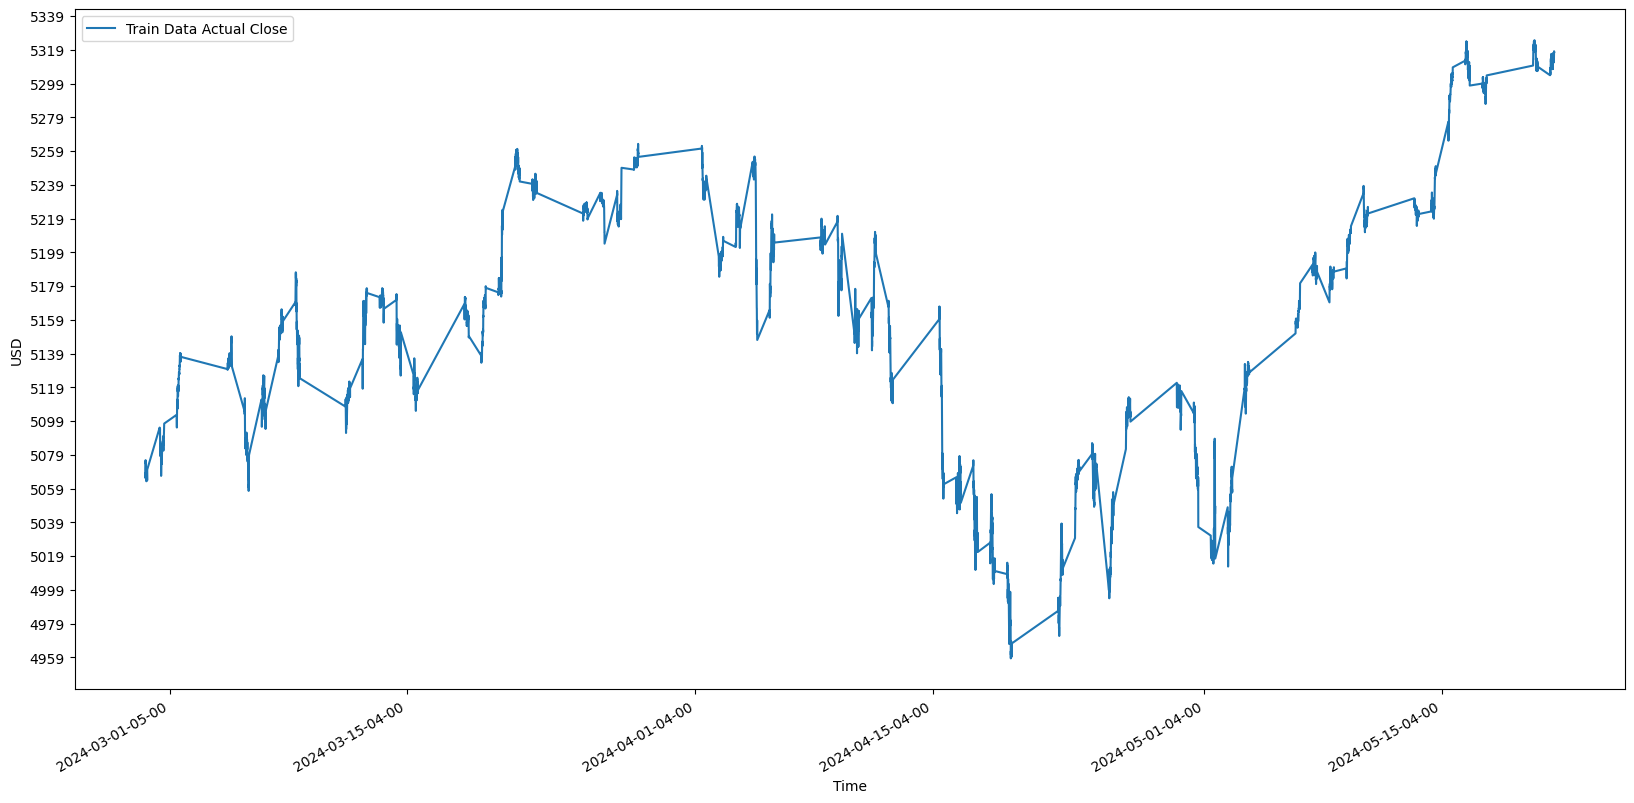

In [16]:
x = df[['Close', 'VMA5', 'VMA10', 'VMA20', 'ADX', 'MACD', 'RSI', 'AD', 'ATR', 'HT_DC']].values
y = df[['NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6']].values

plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H-%M'))
plt.gca().yaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.plot(df['Datetime'], df['Close'], label='Train Data Actual Close')
# plt.plot(df.index, df['Close'], label='Test Data Actual Adj Close')
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

x_sc = MinMaxScaler()
y_sc = MinMaxScaler()
x = x_sc.fit_transform(x)
y = y_sc.fit_transform(y)
time_steps = 24
xtrain, ytrain = [], []
for i in range(time_steps, len(x)):
  xtrain.append(x[i-time_steps:i])
  ytrain.append(y[i])
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
# xtrain = np.reshape(xtrain,(xtrain.shape[0], xtrain.shape[1], 1))
# if resampling=='BorderlineSMOTE2':
# X, Y = BorderlineSMOTE(kind='borderline-2').fit_resample(X, Y)
# LSTM_X_data, LSTM_Y_data = shuffle(LSTM_X_data[1:], LSTM_Y_data[1:], random_state=42)
# t2 = dt.datetime.now()

In [17]:
# class Myloss(keras.losses.Loss):
#     def call(self, real, pre):
#         mse = mean_squared_error(real, pre)
#         diracc = sign_loss(real, pre)
#         return (mse + diracc)
# # def sign_loss(close_price_array, prediction_array):

# #         actual_percent_changes = (close_price_array[:, 1:] - close_price_array[:, :-1]) / close_price_array[:, :-1]
# #         pred_percent_changes = (prediction_array[:, 1:] - prediction_array[:, :-1]) / prediction_array[:, :-1]
# #         actual_directions = tf.math.sign(actual_percent_changes)
# #         pred_directions = tf.math.sign(pred_percent_changes)
# #         correct_predictions = tf.math.reduce_sum(tf.cast(tf.math.equal(actual_directions, pred_directions), tf.float32), axis=1)
# #         directional_accuracy = tf.math.reduce_mean(correct_predictions / (close_price_array.shape[1]-1))*100

# #         return 100-directional_accuracy
# def sign_loss(a, b):
#     av= a[:,1:] - a[:,:-1]
#     bv= b[:,1:] - b[:,:-1]
#     ad= tf.math.tanh(av)
#     bd= tf.math.tanh(bv)
#     c= tf.math.reduce_sum(tf.multiply(ad,bd), axis=1)
#     print(c)
#     return c

In [18]:
def Create_LSTM_Model(unit_per_layer=1000, drop_out=0.5, optimizer='Adam', lr=1e-3):
    # Create model with LSTM & Dense layers
    model = Sequential()
    model.add(LSTM(units=unit_per_layer, input_shape=(time_steps, 10), return_sequences=True))
    model.add(Dropout(drop_out))
    model.add(BatchNormalization())
    model.add(LSTM(units=unit_per_layer))
    model.add(Dropout(drop_out))
    model.add(BatchNormalization())
    model.add(Dense(units=unit_per_layer))
    model.add(Dropout(drop_out))
    model.add(BatchNormalization())
    model.add(Dense(units=6))

    if optimizer.upper()=='ADAM':
        opti_func = Adam(learning_rate=lr, amsgrad=True)
    elif optimizer.upper()=='SGD':
        opti_func = SGD(learning_rate=lr)
    elif optimizer.upper()=='RMSPROP':
        opti_func = RMSprop(learning_rate=lr)

    model.compile(optimizer=opti_func, loss="mean_squared_error", metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    # model.compile(optimizer=opti_func, loss=Myloss(), metrics=Myloss())
    model.summary()

    return model

In [19]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 1000)          4044000   
                                                                 
 dropout_3 (Dropout)         (None, 60, 1000)          0         
                                                                 
 batch_normalization_3 (Bat  (None, 60, 1000)          4000      
 chNormalization)                                                
                                                                 
 lstm_3 (LSTM)               (None, 1000)              8004000   
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 1000)              4000      
 chNormalization)                                     

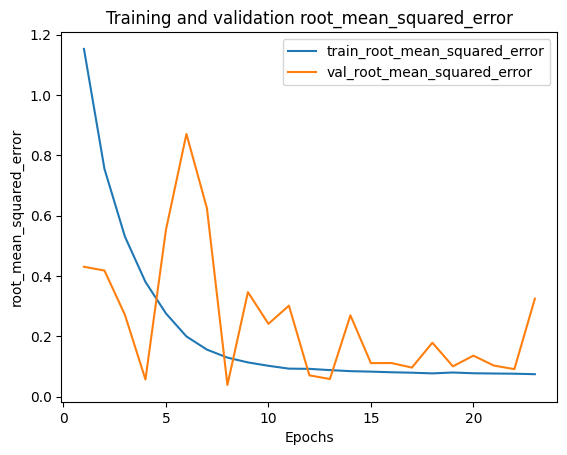

Training time:  0:06:28.236202
141/141 [==============================] - 4s 25ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - mean_absolute_error: 0.1416


[0.023613551631569862, 0.15366700291633606, 0.14158718287944794]

In [20]:
model = Create_LSTM_Model(unit_per_layer=1000, drop_out=0.5, optimizer = 'Adam', lr=5e-4)
earlystopping = EarlyStopping(monitor = 'val_root_mean_squared_error', patience = 15, mode = 'min', min_delta = 0.000001)
t1 = dt.datetime.now()
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.05, shuffle = False)
log = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose = 1, callbacks = [earlystopping]) #validation_split = 0.25, shuffle=False
plot_metric(log, 'root_mean_squared_error')
t2 = dt.datetime.now()
print('Training time: ', t2-t1)

model.evaluate(xtrain, ytrain)

In [21]:
print(len(X_train))

4268


In [22]:
predictions = model.predict(X_test) #Prediction on Data using trained model
output = y_sc.inverse_transform(predictions)
y_test_rescaled = y_sc.inverse_transform(y_test)
output = tf.cast(output, tf.float32)
y_test_rescaled = tf.cast(y_test_rescaled, tf.float32)

def direction_test(actual, predicted):
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)

    # Count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)

    return num_correct/5*100

print("Real:", y_test_rescaled)
print("=============================")
print("predict:", output)
print("=============================")
a = 0
for i in range(1,61):
    b = direction_test(y_test_rescaled[-i], output[-i])
    a += b
    print("direction accuracy = ", b)
print(a/60)
print("=============================")

8/8 [==============================] - 1s 29ms/step
Real: tf.Tensor(
[[5297.28 5298.56 5299.05 5296.19 5296.17 5296.27]
 [5298.56 5299.05 5296.19 5296.17 5296.27 5299.63]
 [5299.05 5296.19 5296.17 5296.27 5299.63 5302.  ]
 ...
 [5316.93 5317.71 5320.72 5321.88 5319.37 5318.61]
 [5317.71 5320.72 5321.88 5319.37 5318.61 5322.6 ]
 [5320.72 5321.88 5319.37 5318.61 5322.6  5321.97]], shape=(225, 6), dtype=float32)
predict: tf.Tensor(
[[5391.505  5394.7544 5393.742  5392.4297 5392.6904 5393.9263]
 [5392.045  5395.2876 5394.2827 5392.9766 5393.2256 5394.448 ]
 [5393.0723 5396.328  5395.3276 5394.012  5394.2656 5395.4883]
 ...
 [5434.874  5439.0044 5437.909  5435.8823 5436.593  5438.412 ]
 [5433.5386 5437.659  5436.601  5434.605  5435.288  5437.1055]
 [5432.574  5436.6816 5435.653  5433.68   5434.3413 5436.153 ]], shape=(225, 6), dtype=float32)
direction accuracy =  80.0
direction accuracy =  60.0
direction accuracy =  20.0
direction accuracy =  20.0
direction accuracy =  80.0
direction accura